# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")
fig_dir = Path('figure').mkdir(parents=True, exist_ok=True)
fig_dir = Path('figure')
result_dir = Path('result').mkdir(parents=True, exist_ok=True)
result_dir = Path('result')

database = "/Users/guru/research/VulnMiner/data/VulMinerV1.db"
conn= connect(database)
random.seed(0)

In [3]:
dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [108]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')

dfplt['category'] = dfplt.apply(lambda row: row['category'] 
if row['category']==row['name'] or row['name']=='-' 
else row['name'], axis=1)
dfplt = dfplt.drop(labels=['name'], axis=1)

fig = px.sunburst(dfplt, 
    path=['category', 'cwe'],
    values='count', 
    color_continuous_scale='Reds',
    color='count',
)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

In [187]:
# Create a treemap from the same data
fig = px.treemap(dfplt, 
    path=['category', 'cwe'],
    values='count',
    color='count',
    color_continuous_scale='Reds',
    title='Treemap'
)

# Update layout if necessary
fig.update_layout(
    autosize=True,
    width=800,
    height=800,
    font=dict( 
        size=16,
    )
)
# Show the treemap
fig.show()
fig.write_image(fig_dir / "vul_statistics.pdf")

In [7]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,cwe,count
76,memcpy,CWE-120,24707
61,char,CWE-119!/CWE-120,23228
3,comparePointers,CWE-570,10958
82,sprintf,CWE-120,7710
87,strlen,CWE-126,7566
57,StrCat,CWE-120,5276
86,strcpy,CWE-120,3962
78,read,"CWE-120, CWE-20",3684
125,open,CWE-362,1945
42,syntaxError,CWE-unknown,1839


# Top 10 vulnerabilities

In [9]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex(result_dir / "top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+-----------------+------------------+---------+
|    | category        | cwe              |   count |
|----+-----------------+------------------+---------|
|  0 | memcpy          | CWE-120          |   24707 |
|  1 | char            | CWE-119!/CWE-120 |   23228 |
|  2 | comparePointers | CWE-570          |   10958 |
|  3 | sprintf         | CWE-120          |    7710 |
|  4 | strlen          | CWE-126          |    7566 |
|  5 | StrCat          | CWE-120          |    5276 |
|  6 | strcpy          | CWE-120          |    3962 |
|  7 | read            | CWE-120, CWE-20  |    3684 |
|  8 | open            | CWE-362          |    1945 |
|  9 | syntaxError     | CWE-unknown      |    1839 |
+----+-----------------+------------------+---------+


<AxesSubplot: >

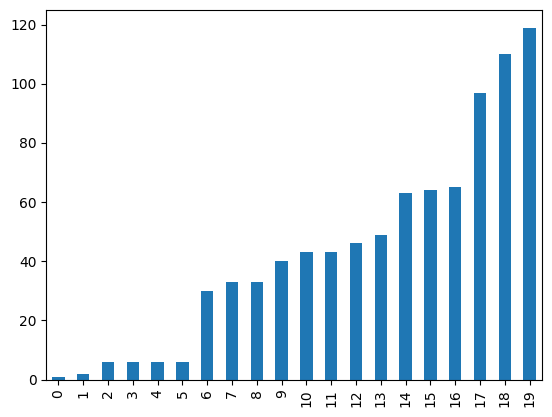

In [10]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [11]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 151  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[114, 117, 0, 101, 43]

## Create a latex table from the statistics of projects

In [12]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, result_dir / 'project_stat.tex'))

In [13]:
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dff_binary['project'] = dff_binary.project.str.split('/').str[-1]

prj_fun = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_fun.groupby(['project', 'cwe']).sum()
prj_f = prj_f.reset_index()
prj_f

,project,cwe,count
0,ARMmbed,Benign,31666
1,ARMmbed,Vulnerable,8729
2,CycloneTCP,Benign,107238
3,CycloneTCP,Vulnerable,12983
4,chromium,Benign,271570
5,chromium,Vulnerable,14717
6,linux,Benign,438785
7,linux,Vulnerable,65439
8,tensorflow,Benign,43048
9,tensorflow,Vulnerable,6538


In [46]:
prj_f = prj_f.rename(columns={'cwe':'cwef', 'count':'#function','project':'projectf'})
prj_stat = prj_stat.rename(columns={'count':'#statement'})

df_dist = pd.concat([prj_stat, prj_f], axis=1, join='inner')
df_dist = df_dist.sort_values(by=['#statement'], ascending=False)
df_dist = df_dist.drop(columns=['projectf', 'cwef'], axis=1)
df_dist = df_dist.set_index(['project', 'cwe']).unstack()
df_dist = pd.concat([df_dist, df_dist.sum().rename('TOTAL').to_frame().T], ignore_index=False)
df_dist.reset_index().to_latex('result/project-stat.tex', index=False)
print(f"Total #statements: {df_dist[-1:][0:2].T[0:2].sum()}")
print(f"Total #functions: {df_dist[-1:][0:2].T[2:4].sum()}")
df_dist

#statement            #function           
cwe            Benign Vulnerable    Benign Vulnerable
ARMmbed        203593       9592     31666       8729
CycloneTCP     294106      18154    107238      12983
chromium       409534      15407    271570      14717
linux         2416761      57524    438785      65439
tensorflow     176176       5485     43048       6538
TOTAL         3500170     106162    892307     108406

In [101]:
dff['cwe'] = dff.cwe.str.replace(r"\['|']", "",regex=True)
dfs_cwe = dfs.cwe.value_counts().reset_index(name='#statements')
dff_cwe = dff.cwe.value_counts().reset_index(name='#functions')

dfs_cwe = dfs_cwe.rename(columns={'index':'cwe'})
dff_cwe = dff_cwe.rename(columns={'index':'cwe'})
df_cwe_count = pd.concat([dfs_cwe, dff_cwe], axis=1).head(10)
df_cwe_count = df_cwe_count.astype({"#functions": int})
df_cwe_count.to_latex('result/cwe-top-10.tex', index=False)
df_cwe_count

,cwe,#statements,cwe,#functions
0,Benign,3500170,Benign,892307
1,CWE-120,43088,CWE-120,52107
2,CWE-119!/CWE-120,23626,CWE-119!/CWE-120,13063
3,CWE-570,10958,CWE-126,8633
4,CWE-126,8111,CWE-457,5946
5,"CWE-120, CWE-20",3863,CWE-unknown,5307
6,CWE-362,2775,"CWE-120, CWE-20",5221
7,CWE-unknown,2507,CWE-570,4188
8,CWE-457,1807,CWE-362,2838
9,CWE-327,1670,CWE-362/CWE-367!,1712


# Show the description of the function-level data

In [102]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)

# shortening the project URL to project name only 
df_freq['top'] = df_freq.apply(lambda row:row['top'].split('/')[-1] if '/' in row['top'] else row['top'], axis=1)

# The freq is the most common value’s frequency. The top is the most common value.
print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False,
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique & top & freq \\
\midrule
context & 70089 &  & 892307 \\
cwe & 2 & Benign & 892307 \\
project & 5 & linux & 504224 \\
\bottomrule
\end{tabular}
\end{table}



In [65]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 3606332
Size of unique statements: 1558946

Size of functions: 1000713
Size of unique functions: 778005


# Token count of function-level data

In [103]:
from gensim.utils import simple_preprocess

fun_token_count = [len(simple_preprocess(x)) for x in dff.code]
stat_token_count = [len(simple_preprocess(x)) for x in dfs.context]

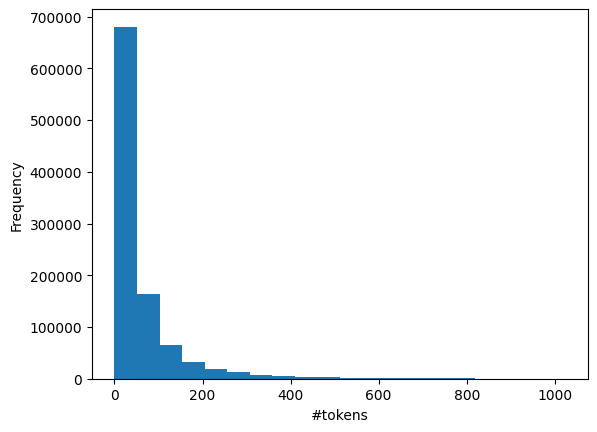

In [92]:
fun_token_count_short = [x for x in fun_token_count if x<=1024]
pd.Series(fun_token_count_short).plot.hist(bins=20)
plt.xlabel('#tokens')
plt.ylabel('frequency')
# plt.title('Function Token Count Distribution')
plt.savefig(fig_dir / 'fun_token_count.pdf')

In [107]:
# Combine descriptions into a DataFrame
combined_df = pd.DataFrame({
    'fun_token_count': pd.Series(stat_token_count).describe(),
    'stat_token_count': pd.Series(fun_token_count).describe()
})

print(combined_df)

       fun_token_count  stat_token_count
count     3.606332e+06      1.000713e+06
mean      3.270633e+00      6.222487e+01
std       2.343737e+00      1.392301e+02
min       0.000000e+00      0.000000e+00
25%       2.000000e+00      1.100000e+01
50%       3.000000e+00      2.800000e+01
75%       4.000000e+00      6.700000e+01
max       5.800000e+01      1.602500e+04


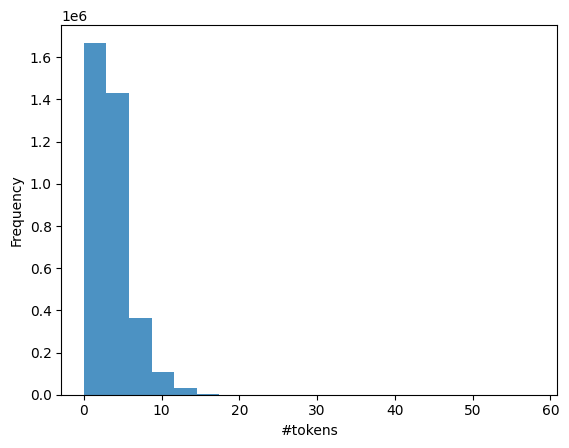

In [95]:
pd.Series(stat_token_count).plot.hist(bins=20, alpha=0.8)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
plt.savefig(fig_dir / 'stat_token_count.pdf')

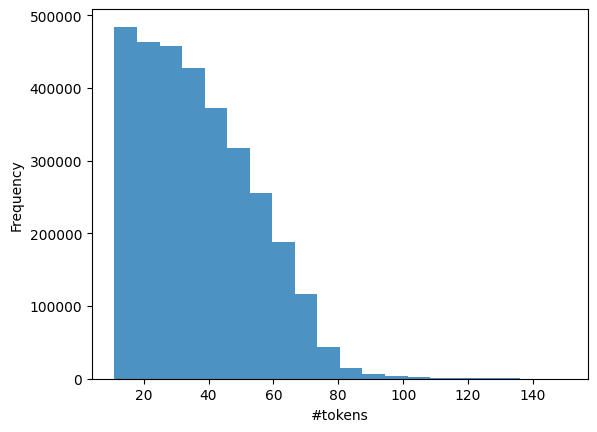

In [96]:
dfs1 = dfs[dfs.context.str.len()<151]
stat_char_len = [len(x) for x in dfs1.context if len(x)>10]
ax = pd.Series(stat_char_len).plot.hist(bins=20, xlabel='#chars', ylabel='#statements',alpha=0.8)
plt.xlabel('#tokens')
plt.ylabel('Frequency')
fighist = ax.get_figure()
fighist.savefig(fig_dir / 'statement-charlen.pdf')

In [174]:
dfs[dfs.file.str.len()<5].reset_index(drop=True)

,file,line,column,defaultlevel,level,category,name,msg,note,cwe,context,helpuri,severity,tool,type,project
0,-,47,['0'],-,-,-,preprocessorErrorDirective,No header in #include,[],CWE-unknown,extern void platform_timer_start(uint16_t slots);,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
1,-,47,['0'],-,-,-,preprocessorErrorDirective,No header in #include,[],CWE-unknown,extern void platform_timer_start(uint16_t slots);,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
2,-,159,"['17', '15', '59', '11', '135']",-,-,-,ctunullpointer,Null pointer dereference: req_list_ptr,['Dereferencing argument req_list_ptr that is ...,CWE-476,"memcpy(ptr, req_list_ptr, req_list_len);",-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
3,-,173,"['17', '15', '59', '11', '135']",-,-,-,ctunullpointer,Null pointer dereference: req_list_ptr,['Dereferencing argument req_list_ptr that is ...,CWE-476,ptr = thread_lowpower_tlv_write_link_metrics_q...,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
4,-,337,"['17', '15', '59', '11', '135']",-,-,-,ctunullpointer,Null pointer dereference: req_list_ptr,['Dereferencing argument req_list_ptr that is ...,CWE-476,ptr = thread_lowpower_tlv_write_link_metrics_q...,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-,34,"['42', '10']",-,-,-,ctuuninitvar,Using argument width_size that points at unini...,"['Using argument width_size', 'Calling functio...",CWE-457,"int* dim[] = {batch_size, height_size, width_s...",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow
68,-,34,"['54', '10']",-,-,-,ctuuninitvar,Using argument depth_size that points at unini...,"['Using argument depth_size', 'Calling functio...",CWE-457,"int* dim[] = {batch_size, height_size, width_s...",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow
69,-,124,"['7', '27', '24', '68']",-,-,-,ctunullpointer,Null pointer dereference: local_client,['Dereferencing argument local_client that is ...,CWE-476,"BuildExecutable(local_client, result, options));",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow
70,-,314,"['7', '27', '24', '68']",-,-,-,ctunullpointer,Null pointer dereference: local_client,['Dereferencing argument local_client that is ...,CWE-476,"return BuildHLOString(stage, result, local_cli...",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow


In [180]:
dfs[dfs.file.str.len()<5].reset_index(drop=True)

,file,line,column,defaultlevel,level,category,name,msg,note,cwe,context,helpuri,severity,tool,type,project
0,-,47,['0'],-,-,-,preprocessorErrorDirective,No header in #include,[],CWE-unknown,extern void platform_timer_start(uint16_t slots);,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
1,-,47,['0'],-,-,-,preprocessorErrorDirective,No header in #include,[],CWE-unknown,extern void platform_timer_start(uint16_t slots);,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
2,-,159,"['17', '15', '59', '11', '135']",-,-,-,ctunullpointer,Null pointer dereference: req_list_ptr,['Dereferencing argument req_list_ptr that is ...,CWE-476,"memcpy(ptr, req_list_ptr, req_list_len);",-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
3,-,173,"['17', '15', '59', '11', '135']",-,-,-,ctunullpointer,Null pointer dereference: req_list_ptr,['Dereferencing argument req_list_ptr that is ...,CWE-476,ptr = thread_lowpower_tlv_write_link_metrics_q...,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
4,-,337,"['17', '15', '59', '11', '135']",-,-,-,ctunullpointer,Null pointer dereference: req_list_ptr,['Dereferencing argument req_list_ptr that is ...,CWE-476,ptr = thread_lowpower_tlv_write_link_metrics_q...,-,error,CppCheck,-,/Users/guru/research/projects/ARMmbed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-,34,"['42', '10']",-,-,-,ctuuninitvar,Using argument width_size that points at unini...,"['Using argument width_size', 'Calling functio...",CWE-457,"int* dim[] = {batch_size, height_size, width_s...",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow
68,-,34,"['54', '10']",-,-,-,ctuuninitvar,Using argument depth_size that points at unini...,"['Using argument depth_size', 'Calling functio...",CWE-457,"int* dim[] = {batch_size, height_size, width_s...",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow
69,-,124,"['7', '27', '24', '68']",-,-,-,ctunullpointer,Null pointer dereference: local_client,['Dereferencing argument local_client that is ...,CWE-476,"BuildExecutable(local_client, result, options));",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow
70,-,314,"['7', '27', '24', '68']",-,-,-,ctunullpointer,Null pointer dereference: local_client,['Dereferencing argument local_client that is ...,CWE-476,"return BuildHLOString(stage, result, local_cli...",-,error,CppCheck,-,/Users/guru/research/projects/tensorflow


In [4]:
from pathlib import Path

file = 'data1/testV3.db'

Path(file).parent.mkdir(parents=True, exist_ok=True)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/guru/miniconda/envs/iotCode/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'code_block' on <module '__main__' (built-in)>
